In [26]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
import plotly

In [27]:
def Regular_1(L,Inh):
    L2=L*L
    Matrix=np.zeros((L2,L2),int)
    rng=np.random.default_rng(seed=1)
    for i in range(L):
        for j in range(L):
            ia=i
            ji=j
            id=i
            jd=j
            if ia+1==L:
                ia=-1
            if id==0:
                id=L
            if jd+1==L:
                jd=-1
            if ji==0:
                ji=L
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else :
                I=1
            Matrix[i*L+j][i*L+jd+1]=1*(2*I-1)## derecha I=0 -1,I=1 1
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else:
                I=1
            Matrix[i*L+j][i*L+ji-1]=-1*(2*I-1)## izquieda
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else:
                I=1
            Matrix[i*L+j][(ia+1)*L+j]=-1*(2*I-1)## arriba 
            I=rng.uniform(0.0, 1.0)
            if I<Inh:
                I=0
            else: 
                I=1
            Matrix[i*L+j][(id-1)*L+j]=-1*(2*I-1)# Abajo
    return Matrix

def small_word_Bi(L,P,Inh):
    Matrix=Regular_1(L,Inh)
    rng=np.random.default_rng(seed=1)
    for i in range(L*L):
        for j in range(L*L):
            if Matrix[i][j]==1 and rng.uniform(0.0, 1.0)<P:
                Matrix[i][j]==0
                Matrix[j][i]==0
                jj=rng.integers(0,L*L-1)
                if jj==i or jj==j:
                    jj=rng.integers(0,L*L-1)
                    Matrix[jj][i]=2
                    Matrix[i][jj]=2
                else:
                    Matrix[jj][i]=2
                    Matrix[i][jj]=2
            elif Matrix[i][j]==-1 and rng.uniform(0.0, 1.0)<P:
                Matrix[i][j]==0
                Matrix[j][i]==0
                jj=rng.integers(0,L*L-1)
                if jj==i or jj==j:
                    jj=rng.integers(0,L*L-1)
                    Matrix[jj][i]=-2
                    Matrix[i][jj]=-2
                else:
                    Matrix[jj][i]=-2
                    Matrix[i][jj]=-2
    for i in range(L*L):
        for j in range(L*L):
            if Matrix[i][j]==2:
                Matrix[i][j]=1
                Matrix[j][i]=1
            elif Matrix[i][j]==-2:
                Matrix[i][j]=-1
                Matrix[j][i]=-1
    return Matrix

def Random_bi(L,  P,  Inh):
    matrix=np.zeros((L*L,L*L),int)
    rng=np.random.default_rng(seed=1)
    for i in range(L*L):
        for j in range(L*L):
            I=rng.uniform(0.0,1.0)
            if I<Inh:
                I=0
            else:
                I=1
            if (matrix[i][j]!=1 or matrix[i][j]!=-1) and rng.uniform(0.0,1.0)<P:
            
                matrix[i][j]=-1*(2*I-1)
                matrix[j][i]=-1*(2*I-1)
    return matrix   
    

In [28]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 100.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [48]:

fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
    # Compilación del programa
    resultado_compilacion = subprocess.run("g++ -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_compilacion.returncode != 0:
        print("Error durante la compilación:")
        print(resultado_compilacion.stderr)
        return None
    
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:,1]
    data=(data - np.mean(data)) / np.std(data)
    n_samples_resampled = int(len(data) * (fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)
    butter = signal.filtfilt(b, a,data_resampled)
    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)
    welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,"welch_data":welch_data,
        "frequencies": frequencies,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [30]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre  
        data = np.loadtxt(nombre)*1e6
        data=(data - np.mean(data)) / np.std(data)
        Datos[i]=data


        frequencies, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)


        frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
        welch_datos[i]=welch_data

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos,   "welch_data":welch_datos,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [40]:
Params={'L': 57, 'P': 0.4965416953500361, 'Inh': 0.1840042178063965, 'Trest': -1.3321936159428258, 'Trelative': 1.8722523128821265, 'C_h': 9.984838343562668, 'Tipo_red': 0}

initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030, Params["Tipo_red"]]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


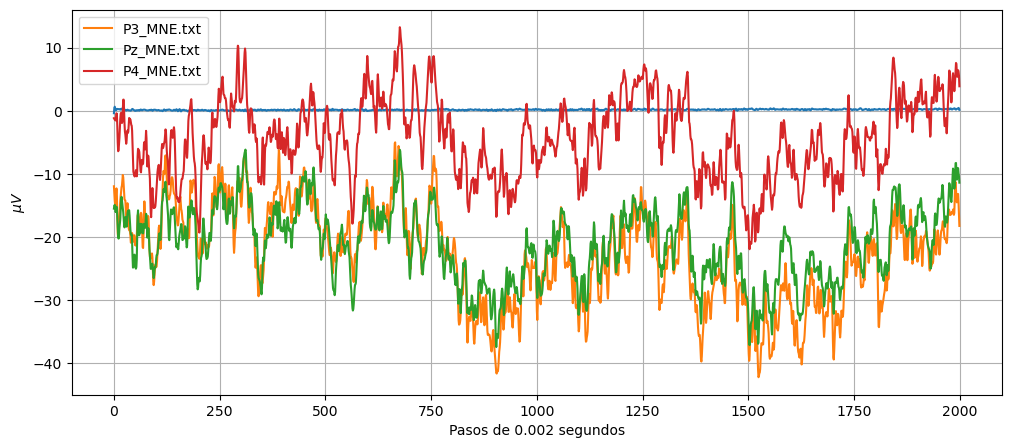

In [41]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["butter"])
for i in range(3):
    ax.plot(reales_total["datos"][i], label=reales_total["Nombres"][i])


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


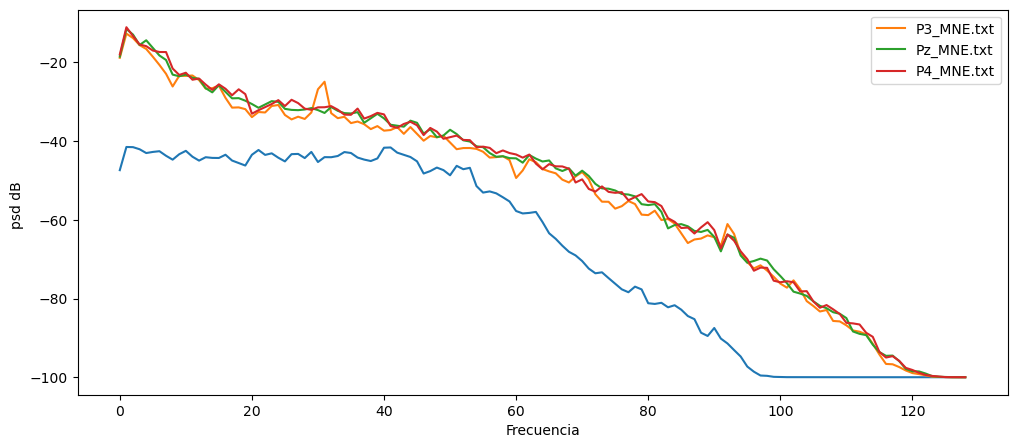

In [47]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["welch_data"])
for i in range(3):
    ax.plot(reales_total["welch_data"][i], label=reales_total["Nombres"][i])


plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [34]:

reales=reales_total["main_Delta"]+reales_total["main_Theta"]+reales_total["main_Alpha"]+reales_total["main_Beta"]

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -15.0, 15.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 10.0)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',0,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        generated_data = generated_data_total["delta"] + generated_data_total["theta"] + generated_data_total["alpha"] + generated_data_total["beta"]
        difference = sum(abs(gd - rd) for gd, rd in zip(generated_data, reales))

        if trial.number > 30 and np.random.rand() < 0.3:  
            params[7] = np.random.random_integers(0, 2) 
            params[2] = np.random.uniform(0,1)  
            params[1] = np.random.uniform(0,1)  

        trial.report(difference, step=trial.number)
        
        
        return difference
    else:
        return float('inf') 
    

# Create and optimize the study
study = optuna.create_study(study_name='4bandas_full_Normal_z_score', storage='sqlite:///Estudios/4bandas_full_Normal_z_score.db')

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=100)


[I 2024-09-25 22:23:39,775] A new study created in RDB with name: 4bandas_full_Normal_z_score
/tmp/ipykernel_34001/1570236376.py:27: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[I 2024-09-25 22:23:47,191] Trial 0 finished with value: inf and parameters: {'L': 34, 'P': 0.4172826744438556, 'Inh': 0.19251068764182122, 'Trest': 3.5478424176227854, 'Trelative': 3.6345983740226977, 'C_h': 6.9471584248926375, 'Tipo_red': 1}. Best is trial 0 with value: inf.
[I 2024-09-25 22:24:15,798] Trial 1 finished with value: 34.9730268386261 and parameters: {'L': 33, 'P': 0.14047636029783728, 'Inh': 0.41234526055294185, 'Trest': -4.132377679782223, 'Trelative': 2.847781970446155, 'C_h': 1.1956441415683028, 'Tipo_red': 2}. Best is trial 1 with value: 34.9730268386261.
[I 2024-09-25 22:24:18,227] Trial 2 finished with value: 33.66870648134443 and parameters: {'L': 22, 'P': 0.9909335706632214, 'Inh': 0.060080928588430615, 'Trest': 1.585829671287911, 'Trel

In [35]:
study = optuna.load_study(study_name='4bandas_full_Normal_max', storage='sqlite:///Estudios/4bandas_full_Normal_max.db')
study.optimize(objective, n_trials=1)


[I 2024-09-25 22:40:14,312] Trial 51 finished with value: 36.07248528520608 and parameters: {'L': 52, 'P': 0.3024813900299425, 'Inh': 0.3360716898827794, 'Trest': -1.4771892426796271, 'Trelative': 1.2823526847143696, 'C_h': 6.765744957354155, 'Tipo_red': 0}. Best is trial 46 with value: 2.9517714347405306.


In [43]:
print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:5]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


4bandas_full_Normal_max

Trial 1:
Params: {'L': 57, 'P': 0.4965416953500361, 'Inh': 0.1840042178063965, 'Trest': -1.3321936159428258, 'Trelative': 1.8722523128821265, 'C_h': 9.984838343562668, 'Tipo_red': 0}
Value: 2.9517714347405306

Trial 2:
Params: {'L': 48, 'P': 0.41275786715345764, 'Inh': 0.007238683161631676, 'Trest': 0.47758296641983994, 'Trelative': 3.0359217762286224, 'C_h': 7.835237327505056, 'Tipo_red': 0}
Value: 4.759819105781498

Trial 3:
Params: {'L': 58, 'P': 0.3149894577501925, 'Inh': 0.19133400845699558, 'Trest': -1.7162094423228702, 'Trelative': 1.2608121263643377, 'C_h': 8.107626995684006, 'Tipo_red': 0}
Value: 4.994678405050701

Trial 4:
Params: {'L': 37, 'P': 0.5706544587027408, 'Inh': 0.22901828788209316, 'Trest': -1.0284432257837375, 'Trelative': 2.8342032944957807, 'C_h': 8.705999864286925, 'Tipo_red': 0}
Value: 6.522936833344611

Trial 5:
Params: {'L': 56, 'P': 0.4020347579149772, 'Inh': 0.28894148056360036, 'Trest': 0.06630754023195418, 'Trelative': 1.36327738

In [44]:
vis.plot_param_importances(study)

In [45]:
vis.plot_parallel_coordinate(study)

In [46]:
optuna.visualization.plot_slice(study)